In [3]:
# CLICK THROUGH RATE PREDICTION

!pip install category_encoders
!pip install deepctr
!pip install tensorflow==2.8.1
!pip install scikeras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import deepctr
import tensorflow as tf
import category_encoders as ce
from tensorflow  import keras
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (classification_report, accuracy_score, precision_score, recall_score, confusion_matrix,
    f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, log_loss)
from sklearn.ensemble import GradientBoostingClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from deepctr.models import DeepFM
from deepctr.feature_column import DenseFeat
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from collections import Counter
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler

# Exploratory Data Analysis

In [4]:
# Reading the dataset
df = pd.read_csv('Avazudataset1.csv')
df.head()

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,1.000000e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,2,15706,320,50,1722,0,35,-1,79
1,1,1.000000e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15704,320,50,1722,0,35,100084,79
2,2,1.000000e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15704,320,50,1722,0,35,100084,79
3,3,1.000000e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15706,320,50,1722,0,35,100084,79
4,4,1.000000e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,...,1,0,18993,320,50,2161,0,35,-1,157


Droping the column with the name 'Unnamed: 0' as it does not give any meaningfull information.

In [5]:
df = df.drop('Unnamed: 0', axis=1)
print("No of rows in dataset: ", len(df))
print("No of columns in dataset: ", len(df.columns))
print("Shape of dataset: ", df.shape)

No of rows in dataset:  1000000
No of columns in dataset:  24
Shape of dataset:  (1000000, 24)


In [6]:
# Having a look at the Summary/Composition of the dataset or Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1000000 non-null  float64
 1   click             1000000 non-null  int64  
 2   hour              1000000 non-null  int64  
 3   C1                1000000 non-null  int64  
 4   banner_pos        1000000 non-null  int64  
 5   site_id           1000000 non-null  object 
 6   site_domain       1000000 non-null  object 
 7   site_category     1000000 non-null  object 
 8   app_id            1000000 non-null  object 
 9   app_domain        1000000 non-null  object 
 10  app_category      1000000 non-null  object 
 11  device_id         1000000 non-null  object 
 12  device_ip         1000000 non-null  object 
 13  device_model      1000000 non-null  object 
 14  device_type       1000000 non-null  int64  
 15  device_conn_type  1000000 non-null  int64  
 16  C

In [7]:
# Statistical summary for the numerical columns.
df.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,9.376260e+18,0.160219,1.410210e+07,1005.088166,0.229922,1.025540,0.223363,18262.203151,318.965808,56.495546,2041.031112,1.452262,190.779388,45505.857239,69.936118
std,5.236903e+18,0.366809,1.493256e+00,1.156928,0.464627,0.453899,0.667164,3510.366302,19.452897,36.546944,441.200965,1.362637,273.439286,49843.810147,38.513846
min,9.984920e+12,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,4.850000e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,15707.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,43.000000
50%,9.830000e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,19251.000000,320.000000,50.000000,2161.000000,1.000000,39.000000,-1.000000,61.000000
75%,1.370000e+19,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,21153.000000,320.000000,50.000000,2420.000000,3.000000,297.000000,100084.000000,79.000000
max,1.840000e+19,1.000000,1.410210e+07,1012.000000,7.000000,5.000000,5.000000,21705.000000,1024.000000,1024.000000,2497.000000,3.000000,1835.000000,100248.000000,195.000000


# Understanding the distribution of the labels/classes in a binary classification problem and Visualizing the target column.


0    839781
1    160219
Name: click, dtype: int64




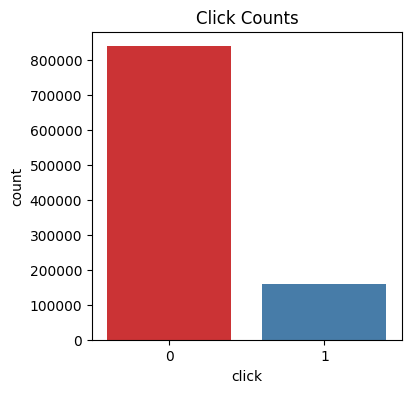

In [8]:
print(df['click'].value_counts())
print("\n")

# Visualization of Target feature
plt.figure(figsize=(4, 4))
sns.countplot(x='click', data=df, palette='Set1')
plt.title('Click Counts')
plt.show()

The column id is not predictive of the target variable, it will not be helpful for training a machine learning model so dropping the column.


In [9]:
# Dropping 'id' as it does not help us during model training
df = df.drop('id', axis=1)

In [10]:
# Splitting the columns into numerical and categorical columns to plot the histogram of the numerical columns

numerical_columns = [col for col in df.columns if df[col].dtype != "object"]
categorical_columns = [col for col in df.columns if df[col].dtype == "object"]

print("Numerical features =", numerical_columns)
print("Categorical features =", categorical_columns)

Numerical features = ['click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
Categorical features = ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


# Histogram Plotting for Numerical Features

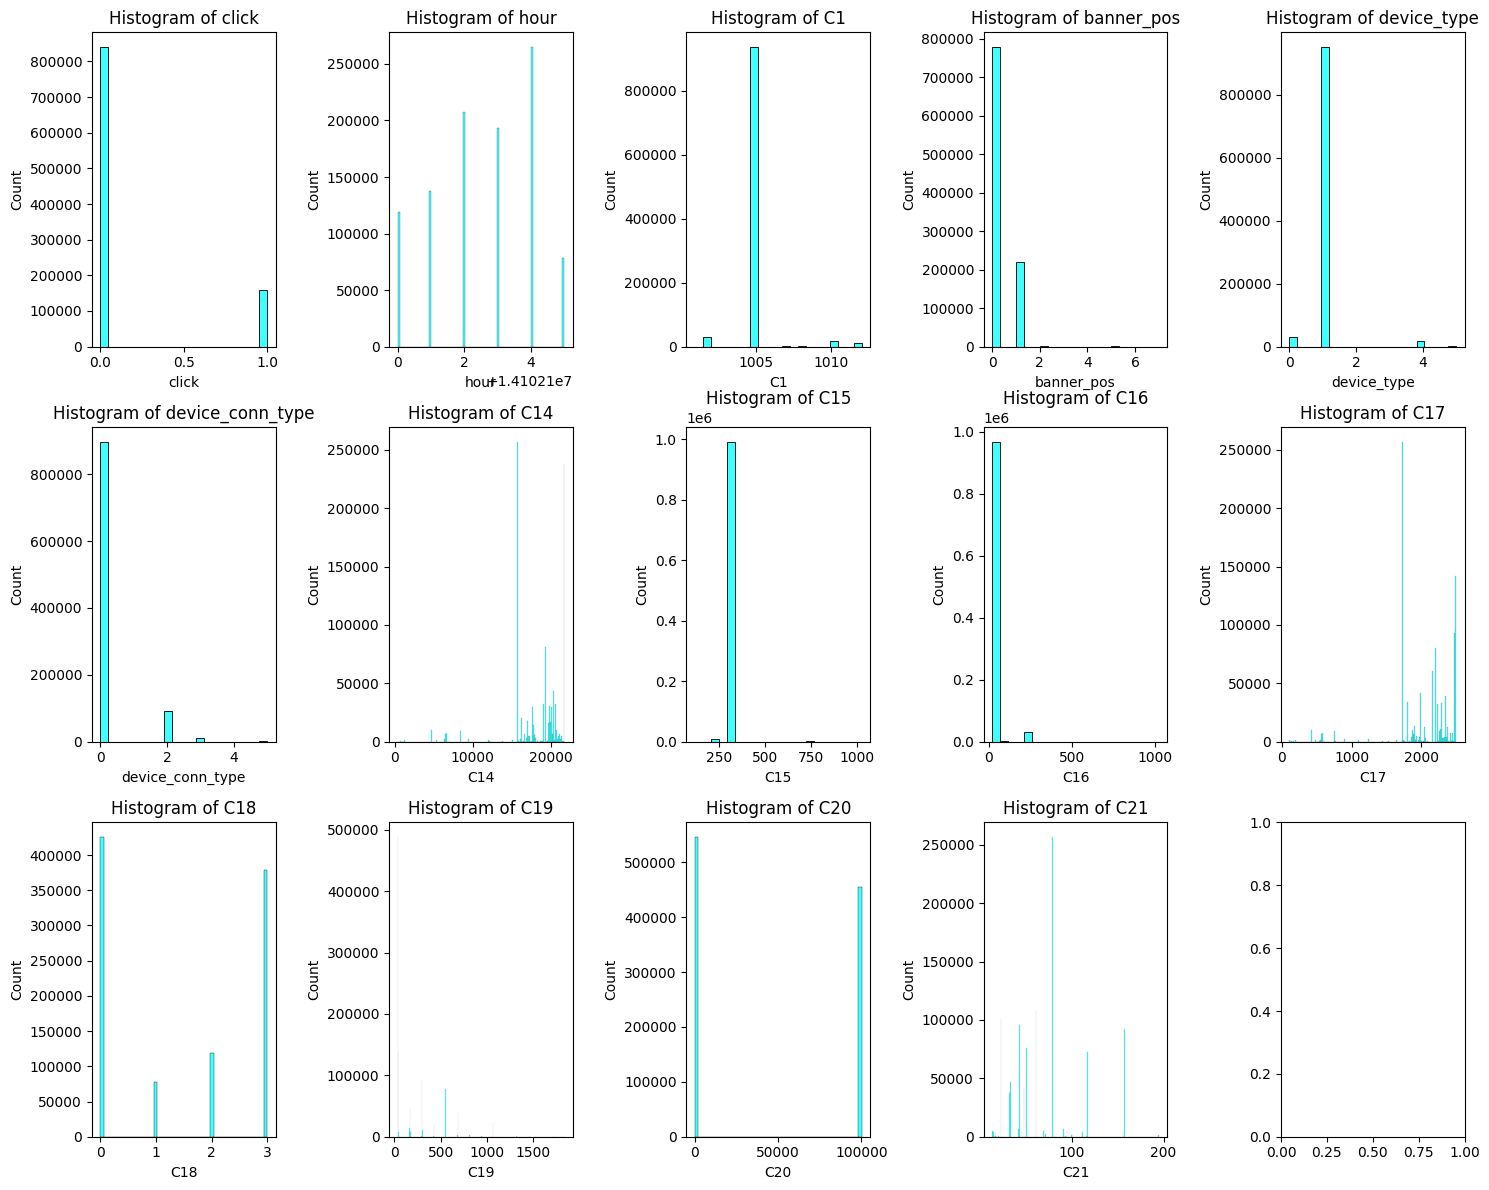

In [11]:
def numerical_histogram(df, selected_columns):
    num_cols_per_row = 5
    num_rows = (len(selected_columns) + num_cols_per_row - 1) // num_cols_per_row
    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 4 * num_rows))
    for i, col in enumerate(selected_columns):
        row = i // num_cols_per_row
        col_idx = i % num_cols_per_row
        ax = axes[row, col_idx]
        sns.histplot(data=df, x=col, color='cyan', ax=ax)
        ax.set_title(f'Histogram of {col}')

    plt.tight_layout()
    plt.show()

numerical_histogram(df, numerical_columns)

Checking for Null values in the dataframe as NAN Values affects the model affects the model.

In [12]:
df.isnull().sum()

click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [13]:
# Having a look at unique values in the Dataframe
df.nunique()

click                    2
hour                     6
C1                       7
banner_pos               7
site_id               2075
site_domain           2030
site_category           21
app_id                2309
app_domain             156
app_category            23
device_id            83427
device_ip           312955
device_model          4581
device_type              4
device_conn_type         4
C14                    606
C15                      8
C16                      9
C17                    162
C18                      4
C19                     41
C20                    161
C21                     35
dtype: int64

In [14]:
# Seeing the composition of unique values in every columns in the dataframe

for col in df.columns:
    unique_counts = df[col].value_counts()
    print(f"Unique value counts for column '{col}':\n{unique_counts}\n")

Unique value counts for column 'click':
0    839781
1    160219
Name: click, dtype: int64

Unique value counts for column 'hour':
14102104    264711
14102102    207471
14102103    193355
14102101    137442
14102100    119006
14102105     78015
Name: hour, dtype: int64

Unique value counts for column 'C1':
1005    935852
1002     31219
1010     18488
1012     11916
1008      1563
1007       855
1001       107
Name: C1, dtype: int64

Unique value counts for column 'banner_pos':
0    777714
1    220187
5      1563
2       336
7       150
4        48
3         2
Name: banner_pos, dtype: int64

Unique value counts for column 'site_id':
85f751fd    332893
1fbe01fe    232096
d9750ee7     38603
e151e245     32359
5b08c53b     16455
             ...  
ba7311c2         1
be4e229f         1
3f7c99d7         1
b3e07dd2         1
f04d5c61         1
Name: site_id, Length: 2075, dtype: int64

Unique value counts for column 'site_domain':
c4e18dd6    348412
f3845767    232096
98572c79     41031
7e0916

From the above we can see that the amount of '-1' in the column 'C20' is more. The presence of -1 in the data is equall to the presence of NAN values in the Data so removing those columns

In [15]:
print(df['C20'].value_counts(normalize = True))
# As we can see that around 55% of the values are -1

-1         0.545390
 100111    0.095626
 100084    0.075248
 100083    0.031234
 100077    0.027020
             ...   
 100178    0.000003
 100078    0.000001
 100169    0.000001
 100059    0.000001
 100132    0.000001
Name: C20, Length: 161, dtype: float64


Visualizing the relationship between features to identify patterns and trends in the data.
We can observe that the majority of clicks are concentrated within the range of 0 to 1 in relation with Banner position and also a substantial proportion of clicks falls in 1005 and 1002 in relation with C1.

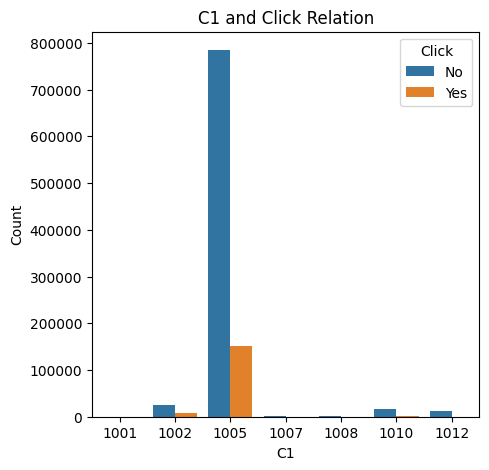

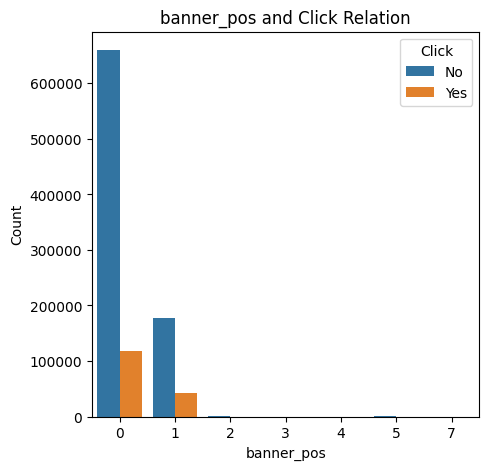

In [16]:
columns_to_plot = ['C1', 'banner_pos']

for col in columns_to_plot:
    plt.figure(figsize=(5, 5))
    sns.countplot(x=col, hue='click', data=df)
    plt.title(f"{col} and Click Relation")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Click", labels=["No", "Yes"])
    plt.show()


# CORRELATION HEATMAP
The heatmap indicates several correlations within the dataset. Notably, there is a positive correlation between "device type" and "C1," as well as a strong positive correlation between "C14" and "C17." Conversely, "C21" and "C18" are strongly negatively correlated. It's important to address these correlations during feature engineering to prevent issues such as overfitting or redundancy. This involves dropping some features that exhibit strong correlations, ensuring the model's stability and interpretability.

<ipython-input-17-a91e8f289810>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


Text(0.5, 1.0, 'Correlations between numerical columns')

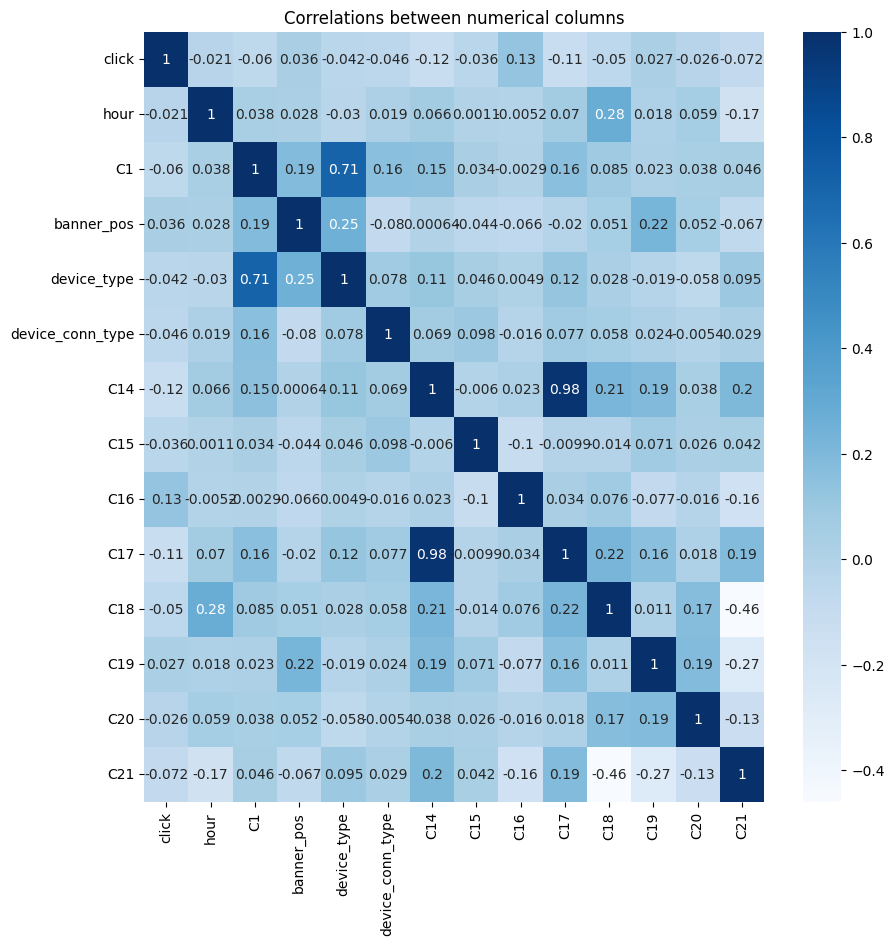

In [17]:
corr = df.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True, cmap='Blues')
plt.title("Correlations between numerical columns")

# Feature Engineering

As mentioned in EDA Dropping 'C1' because it is highly correlated to with device type and also C1 is anonymous.
'C14' is dropped because its strongly positively correlated with C17.
Dropping 'C20' because its strongly negatively correlatedd with C18.
Dropping 'C20' as it mostly has -1 which is also equal to NAN values.

In [18]:
df = df.drop(columns = ['C14', 'C1','C21', 'C20'])

In [19]:
# Converting timestamp to a string and split into components
# Just used time in the hour column because only time in the hour columns differs
# Year, Month and Date all are same for the whole dataset

df['hour'] = df['hour'].astype(str)
df['time'] = df['hour'].str[6:]

In [20]:
# Dropping old hour column as its not necessary
df = df.drop('hour', axis=1)

# Handling Outliers
During EDA process we have seen that there were some outliers in column C15, C16, C19
Dealing with outliers by capping.

In [21]:
outlier_columns = ['C15', 'C16', 'C19']

def cap_outliers(column):
    per_98 = np.percentile(column, 98)
    return np.where(column >= per_98, per_98, column)
# Applying the function to each column
df[outlier_columns] = df[outlier_columns].apply(cap_outliers)

df.head()

,click,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,time
0,0,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,320.0,50.0,1722,0,35.0,00
1,0,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,320.0,50.0,1722,0,35.0,00
2,0,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,320.0,50.0,1722,0,35.0,00
3,0,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,320.0,50.0,1722,0,35.0,00
4,0,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,320.0,50.0,2161,0,35.0,00


Splitting target column and other independent columns.

In [22]:
X = df.drop('click', axis=1)
y = df['click'] # Target column

In [23]:
# Converting the column time to integer data type.

X['time'] = pd.to_numeric(X['time'], errors='coerce')

In [24]:
X_numerical = [col for col in X.columns if X[col].dtype != "object"]
X_categorical = [col for col in X.columns if X[col].dtype == "object"]

print("Numerical features =", X_numerical)
print("Categorical features =", X_categorical)

Numerical features = ['banner_pos', 'device_type', 'device_conn_type', 'C15', 'C16', 'C17', 'C18', 'C19', 'time']
Categorical features = ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


# Train Test Split
As I could not find a seperated dataset for testing i am splitting the dataset into 70% for training and 15% for the validation and the rest 15% for testing.


In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Handling Categorical Columns

In [26]:
# Performing Target encoding to treat categorical variables
target_encoder = ce.TargetEncoder()
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_val_encoded = target_encoder.transform(X_val)
X_test_encoded = target_encoder.transform(X_test)

**Creating copy of original dataset for safety purposes.**

In [27]:
# Creating copies of the original datasets.
X_train_scaled = X_train_encoded.copy()
X_val_scaled = X_val_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Performing MinMax Scaling
Scaling down the numerical columns using MinMax Scaler
Categorical columns has not been scaled down because meaningful relationship between Categorical variables and the target variable will be lost.

In [28]:
columns_to_scale = ['banner_pos', 'device_type', 'device_conn_type', 'C15', 'C16', 'C17', 'C18', 'C19', 'time']

scaler = MinMaxScaler() # Initializing the scaler

# Fit and transform the scaler on the selected columns
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_val_scaled[columns_to_scale] = scaler.transform(X_val_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

# Performing Sampling using SMOTE - Oversampling

In [29]:
# Initialize SMOTE
smote = SMOTE()
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_scaled, y_train)
print("After Oversampling:")
print("Number of instances in each class:", np.bincount(y_train_oversampled))

# Checking class distribution
print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_train_oversampled))

After Oversampling:
Number of instances in each class: [587823 587823]
Original dataset shape: Counter({0: 587823, 1: 112177})
Resampled dataset shape: Counter({1: 587823, 0: 587823})


## Defining functions to evaluate models


In [30]:
def evaluate_model(y_true, y_pred, y_scores, dataset_name="Validation"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)

    print(f"{dataset_name} Set Classification Report:\n", classification_report(y_true, y_pred))
    print(f"{dataset_name} Set Accuracy:", accuracy)
    print(f"{dataset_name} Set Precision:", precision)
    print(f"{dataset_name} Set Recall:", recall)
    print(f"{dataset_name} Set F1 Score:", f1)
    print(f"{dataset_name} Set ROC AUC:", roc_auc)

    # Plotting ROC curve
    plot_roc_curve(y_true, y_scores, title=f'Receiver Operating Characteristic ({dataset_name} Set)')

    # Plotting confusion matrix
    plot_confusion_matrix(y_true, y_pred, title=f'{dataset_name} Set Confusion Matrix')

def plot_roc_curve(y_true, y_scores, title="Receiver Operating Characteristic"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc_curve = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap='plasma'):
    cm = confusion_matrix(y_true, y_pred)  # Computing confusion matrix
    plt.figure(figsize=(4, 4))     # Plotting heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, cbar=False)
    plt.xlabel('Predicted labels') # Adding labels and titles
    plt.ylabel('True labels')
    plt.title(title)
    plt.xticks(np.arange(2) + 0.5, ['Negative', 'Positive'])
    plt.yticks(np.arange(2) + 0.5, ['Negative', 'Positive'], rotation=0)
    plt.show()

In [ ]:
accuracies, precisions, recalls, f1_scores, roc_aucs = [], [], [], [], []

# Machine Learning Model
# Logistic Regression with Stochastic Gradient Descent

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best Parameters: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 100, 'penalty': 'l1', 'tol': 0.001}
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.85    125906
           1       0.32      0.48      0.39     24094

    accuracy                           0.75    150000
   macro avg       0.61      0.64      0.62    150000
weighted avg       0.80      0.75      0.77    150000

Validation Set Accuracy: 0.7531733333333334
Validation Set Precision: 0.32149759787950744
Validation Set Recall: 0.48327384411056695
Validation Set F1 Score: 0.3861254808330017
Validation Set ROC AUC: 0.7334777408828485


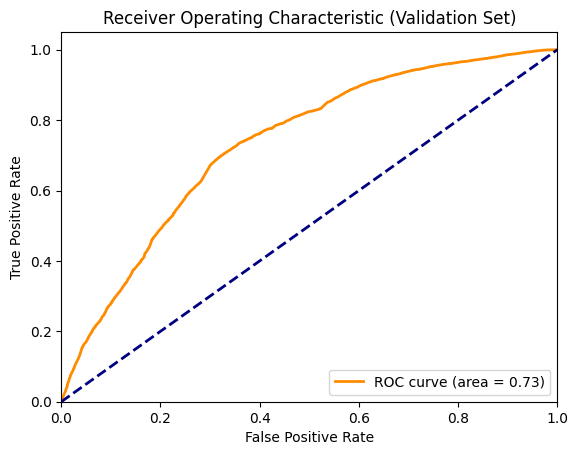

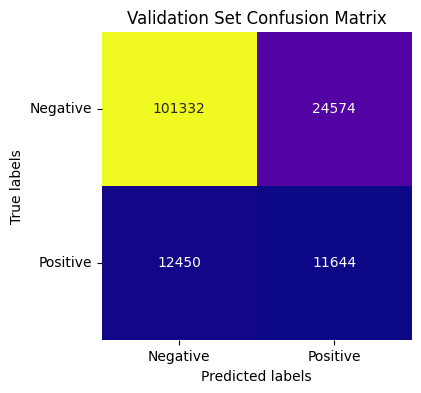

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.85    126052
           1       0.32      0.48      0.38     23948

    accuracy                           0.75    150000
   macro avg       0.61      0.64      0.61    150000
weighted avg       0.80      0.75      0.77    150000

Test Set Accuracy: 0.7526
Test Set Precision: 0.3190641152534917
Test Set Recall: 0.4845916151661934
Test Set F1 Score: 0.3847811671087533
Test Set ROC AUC: 0.7292843868627321


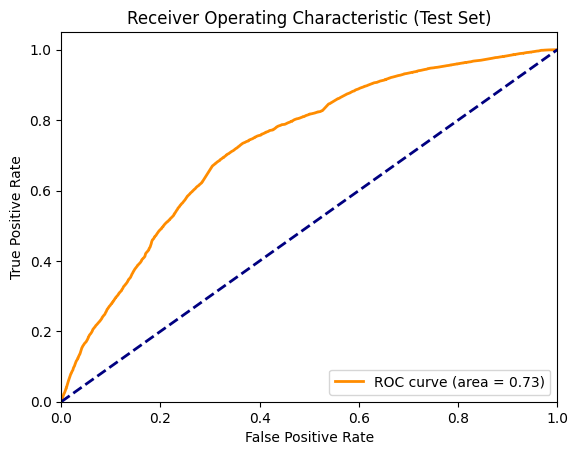

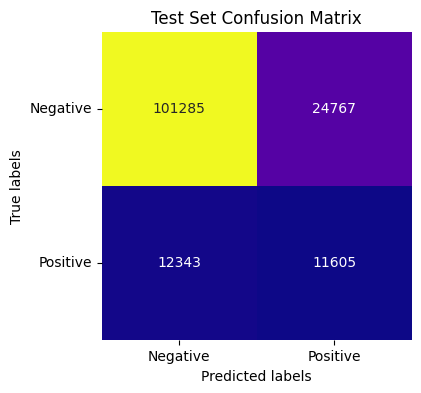

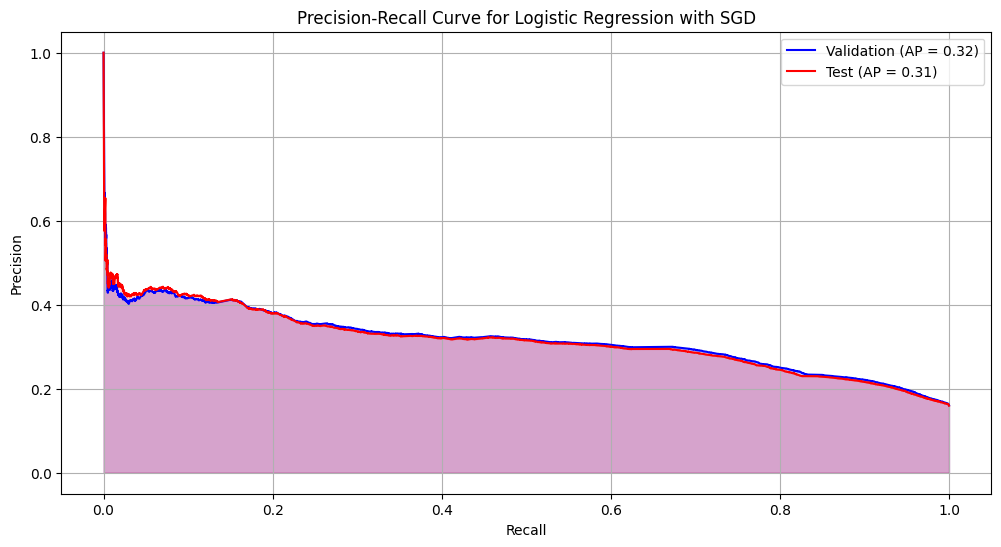

In [32]:
# Creating a Logistic Regression model with SGD
LogReg_SGD = SGDClassifier(loss='log', random_state=42)
recall, precision, accuracy = [], [], []
# Defining the hyperparameters and their possible values for tuning.
param_grid_LRSGD = {'alpha': [0.001, 0.01, 0.1], 'max_iter': [100, 500, 1000], 'learning_rate': ['constant', 'optimal'],
    'eta0': [0.01, 0.1], 'tol': [1e-3, 1e-2], 'penalty': ['l1', 'l2']}

# Performing GridSearchCV
grid_search_LRSGD = GridSearchCV(LogReg_SGD, param_grid_LRSGD, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_LRSGD.fit(X_train_oversampled, y_train_oversampled)
print("Best Parameters:", grid_search_LRSGD.best_params_) # Printing the best parameters

# Getting the best model with the best hyperparameters
best_LRSGD = grid_search_LRSGD.best_estimator_

# Evaluating the model on the validation set
y_val_pred_proba_LRSGD = best_LRSGD.predict_proba(X_val_scaled)[:, 1] # Probabilities are used to calculate AUC and ROC Curves
y_val_pred_LRSGD = best_LRSGD.predict(X_val_scaled)
evaluate_model(y_val, y_val_pred_LRSGD, y_val_pred_proba_LRSGD, "Validation")

# Evaluating the model on the test set
y_test_pred_proba_LRSGD = best_LRSGD.predict_proba(X_test_scaled)[:, 1]
y_test_pred_LRSGD = best_LRSGD.predict(X_test_scaled)

accuracies.append(accuracy_score(y_test, y_test_pred_LRSGD))
precisions.append(precision_score(y_test, y_test_pred_LRSGD))
recalls.append(recall_score(y_test, y_test_pred_LRSGD))
f1_scores.append(f1_score(y_test, y_test_pred_LRSGD))
roc_aucs.append(roc_auc_score(y_test, y_test_pred_proba_LRSGD))

evaluate_model(y_test, y_test_pred_LRSGD, y_test_pred_proba_LRSGD, "Test")

# Computing Precision-Recall values for validation set
precisions_val_LRSGD, recalls_val_LRSGD, _ = precision_recall_curve(y_val, y_val_pred_proba_LRSGD)
average_precision_val_LRSGD = average_precision_score(y_val, y_val_pred_proba_LRSGD)

# Compute Precision-Recall values for test set
precisions_test_LRSGD, recalls_test_LRSGD, _ = precision_recall_curve(y_test, y_test_pred_proba_LRSGD)
average_precision_test_LRSGD = average_precision_score(y_test, y_test_pred_proba_LRSGD)

# Plotting the Precision-Recall curves
plt.figure(figsize=(12, 6))
plt.plot(recalls_val_LRSGD, precisions_val_LRSGD, color='blue',
         label=f'Validation (AP = {average_precision_val_LRSGD:.2f})') # Plotting for validation data
plt.plot(recalls_test_LRSGD, precisions_test_LRSGD, color='red',
         label=f'Test (AP = {average_precision_test_LRSGD:.2f})') # Plotting for test data
plt.fill_between(recalls_val_LRSGD, precisions_val_LRSGD, color='blue', alpha=0.2) # Filling the area between curves with colours
plt.fill_between(recalls_test_LRSGD, precisions_test_LRSGD, color='red', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression with SGD')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss for Machine learning Model

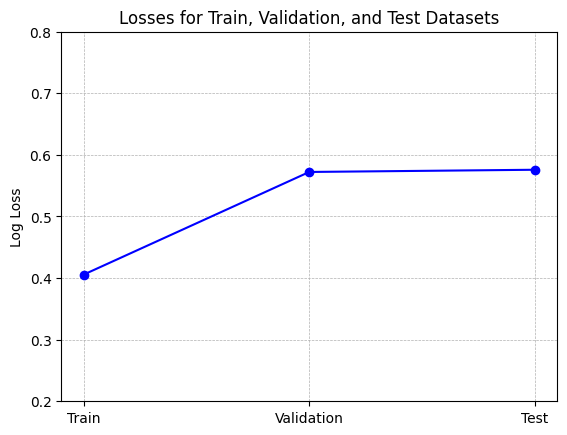

In [33]:
y_train_prob_LRSGD = best_LRSGD.predict_proba(X_train_oversampled)[:, 1] # Calculating predicted probabilities Training Data
train_loss_LRSGD = log_loss(y_train_oversampled, y_train_prob_LRSGD) # Calculate binary cross-entropy loss for the training set
val_loss_LRSGD = log_loss(y_val, y_val_pred_proba_LRSGD)
test_loss_LRSGD = log_loss(y_test, y_test_pred_proba_LRSGD)

loss_values_LRSGD = [train_loss_LRSGD, val_loss_LRSGD, test_loss_LRSGD] # Creating a seperate list
datasets_LRSGD = ['Train', 'Validation', 'Test']
plt.plot(datasets_LRSGD, loss_values_LRSGD, marker='o', color='b', linestyle='-')
plt.title("Losses for Train, Validation, and Test Datasets")
plt.ylabel("Log Loss")
plt.ylim(0.2, 0.8)  # Set y-axis limits
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Ensemble Model
# Gradient Boosted Decision Trees with Feed Forward Neural Network Model.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.69      0.78    125906
           1       0.28      0.65      0.39     24094

    accuracy                           0.68    150000
   macro avg       0.60      0.67      0.59    150000
weighted avg       0.81      0.68      0.72    150000

Validation Set Accuracy: 0.67952
Validation Set Precision: 0.2828315762779408
Validation Set Recall: 0.6480451564704905
Validation Set F1 Score: 0.3937957124842371
Validation Set ROC AUC: 0.7069796234267648


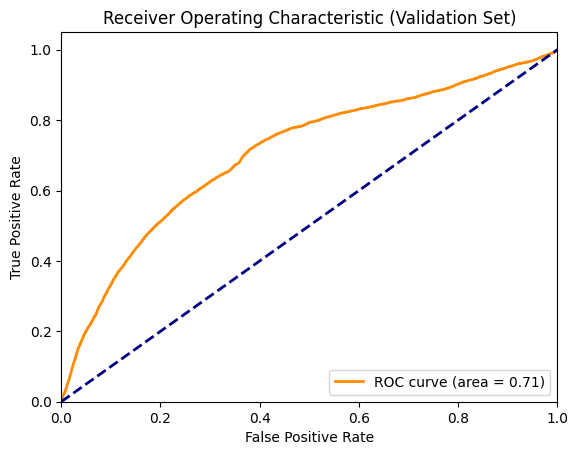

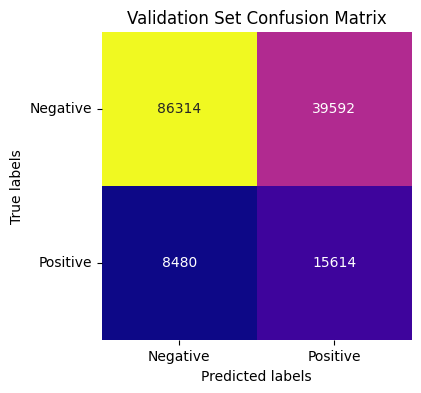

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.68      0.78    126052
           1       0.28      0.65      0.39     23948

    accuracy                           0.68    150000
   macro avg       0.60      0.67      0.59    150000
weighted avg       0.81      0.68      0.72    150000

Test Set Accuracy: 0.6781933333333333
Test Set Precision: 0.2802681265470576
Test Set Recall: 0.6477367629864706
Test Set F1 Score: 0.39124787187086196
Test Set ROC AUC: 0.7040217062846652


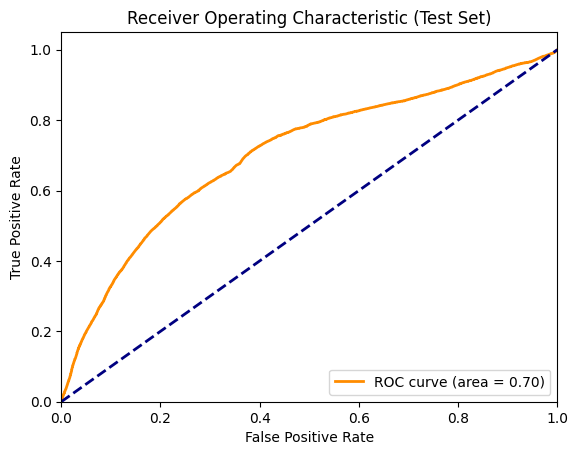

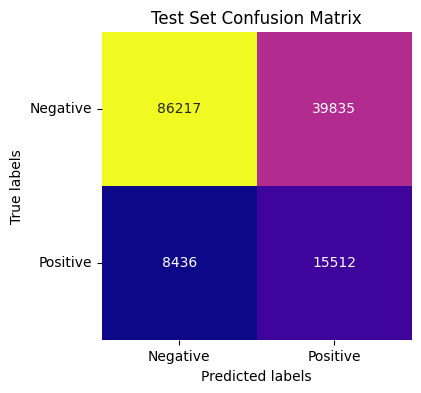

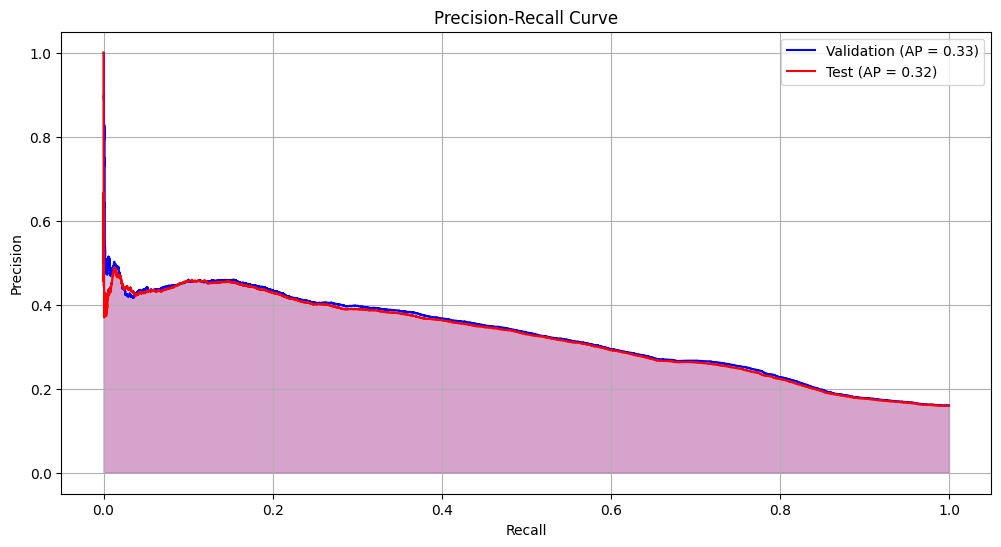

In [34]:
best_params_GBDT = {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 40, 'n_estimators': 1000} # Directly using the best parameters in this model from the previous approaches

gbdt = GradientBoostingClassifier(**best_params_GBDT, random_state=42)

gbdt.fit(X_train_oversampled, y_train_oversampled)

y_train_pred_GBDT = gbdt.predict(X_train_oversampled) # Generating predictions on the training data using the trained GBDT model.

residuals = y_train_oversampled - y_train_pred_GBDT # Calculating residuals.

residuals_encoded = to_categorical(residuals + 1) # Converting residuals into one hot encoded values.

def create_model_FNN():
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_oversampled.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(3, activation='softmax')])  # 3 classes for residuals
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Created early stopping callback to monitor the validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# KerasClassifier is created using the previously defined FNN model function (create_model_FNN)
fnn = KerasClassifier(build_fn=create_model_FNN, epochs=30, batch_size=124, verbose=0)

fnn.fit(X_train_oversampled, residuals_encoded, validation_split=0.1, callbacks=[early_stop])

# Making predictions using both models
y_val_gbdt_pred = gbdt.predict(X_val_scaled)

y_val_fnn_correction = fnn.predict(X_val_scaled) - 1 # FNN predictions are shifted by -1 to match the original residuals.

y_val_fnn_correction_single = np.argmax(y_val_fnn_correction, axis=1) - 1 # Converting the fnn predictions to a single array.

y_val_combined_pred_GBDT = y_val_gbdt_pred + y_val_fnn_correction_single # Summing up both predictions

y_val_combined_pred_GBDT = (y_val_combined_pred_GBDT > 0.5).astype(int) # Thresholded at 0.5 to obtain binary class labels 0 or 1.

y_val_gbdt_probs = gbdt.predict_proba(X_val_scaled)[:, 1] # Predict probabilities on validation set using GBDT model.

y_val_fnn_correction_probs = fnn.predict_proba(X_val_scaled)[:, 1] # Predict probabilities on validation set using FNN model.

y_val_combined_probs = (y_val_gbdt_probs + y_val_fnn_correction_probs) / 2 # Combining both the probabilities.

evaluate_model(y_val, y_val_combined_pred_GBDT, y_val_combined_probs, "Validation") # Evaluating the model on the validation set.

# Doing the same for the test data
y_test_gbdt_pred = gbdt.predict(X_test_scaled)

y_test_fnn_correction = fnn.predict(X_test_scaled) - 1

y_test_fnn_correction_single = np.argmax(y_test_fnn_correction, axis=1) - 1

y_test_combined_pred_GBDT = y_test_gbdt_pred + y_test_fnn_correction_single

y_test_combined_pred_GBDT = (y_test_combined_pred_GBDT > 0.5).astype(int)

y_test_gbdt_probs = gbdt.predict_proba(X_test_scaled)[:, 1]

y_test_fnn_correction_probs = fnn.predict_proba(X_test_scaled)[:, 1]

y_test_combined_probs = (y_test_gbdt_probs + y_test_fnn_correction_probs) / 2

accuracies.append(accuracy_score(y_test, y_test_combined_pred_GBDT))
precisions.append(precision_score(y_test, y_test_combined_pred_GBDT))
recalls.append(recall_score(y_test, y_test_combined_pred_GBDT))
f1_scores.append(f1_score(y_test, y_test_combined_pred_GBDT))
roc_aucs.append(roc_auc_score(y_test, y_test_combined_probs))

evaluate_model(y_test, y_test_combined_pred_GBDT, y_test_combined_probs, "Test")

# PLOTTING PRECISION RECALL CURVE

precisions_val, recalls_val, _ = precision_recall_curve(y_val, y_val_combined_probs) # For Validation Data
average_precision_val = average_precision_score(y_val, y_val_combined_probs)

precisions_test, recalls_test, _ = precision_recall_curve(y_test, y_test_combined_probs) # For Test Data
average_precision_test = average_precision_score(y_test, y_test_combined_probs)

plt.figure(figsize=(12, 6))
plt.plot(recalls_val, precisions_val, color='blue', label=f'Validation (AP = {average_precision_val:.2f})')
plt.plot(recalls_test, precisions_test, color='red', label=f'Test (AP = {average_precision_test:.2f})')
plt.fill_between(recalls_val, precisions_val, color='blue', alpha=0.2)
plt.fill_between(recalls_test, precisions_test, color='red', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss for Ensemble Model (GBDT+FNN).

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


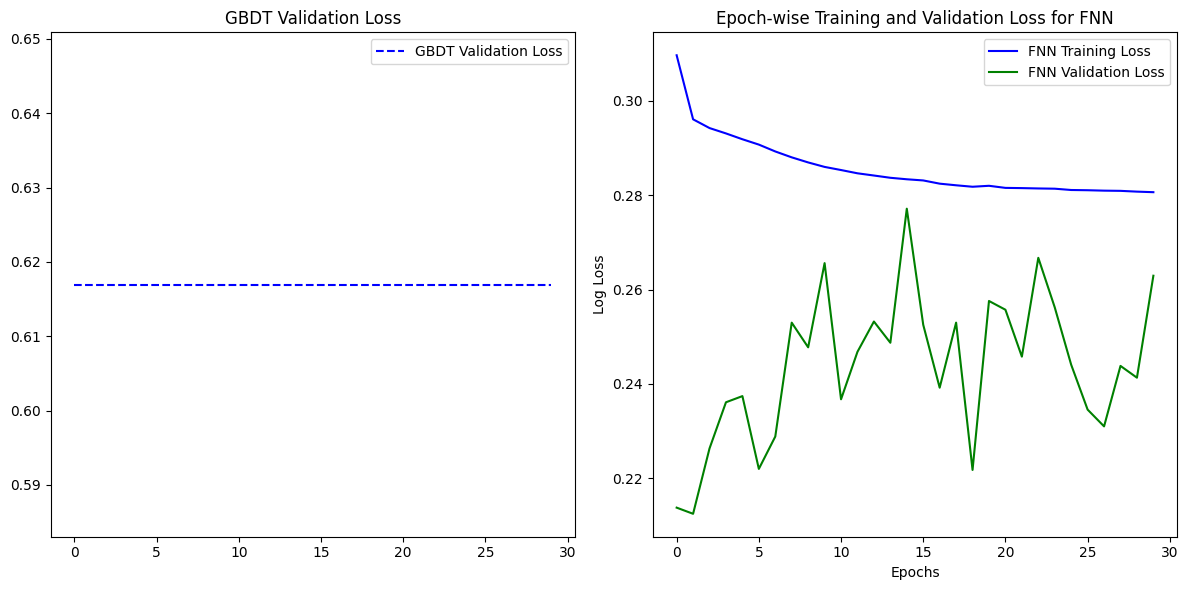

In [35]:
history_fnn = fnn.fit(X_train_oversampled, residuals_encoded, validation_split=0.1, callbacks=[early_stop])

history_fnn = fnn.model_.history

# Extracting training loss from the FNN model's history
training_losses_fnn = history_fnn.history['loss']

# Extracting validation loss from the FNN model's history
validation_losses_fnn = history_fnn.history['val_loss']

# Calculating the GBDT loss on the validation set.
y_val_gbdt_probs = gbdt.predict_proba(X_val_scaled)[:, 1]

gbdt_loss = log_loss(y_val, y_val_gbdt_probs)

plt.figure(figsize=(12, 6)) # Plotting the losses for GBDT and FNN models separately

# Plotting GBDT loss
plt.subplot(1, 2, 1)
plt.plot([gbdt_loss] * len(training_losses_fnn), label='GBDT Validation Loss', color='blue', linestyle='--')
plt.title('GBDT Validation Loss')
plt.legend()

# Plotting FNN losses
plt.subplot(1, 2, 2)
plt.plot(training_losses_fnn, label='FNN Training Loss', color='blue')
plt.plot(validation_losses_fnn, label='FNN Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Epoch-wise Training and Validation Loss for FNN')
plt.legend()
plt.tight_layout()
plt.show()

# Deep Learning Model
# DeepFM - Factorization Machines with Deep Neural Networks

Epoch 1/50
4593/4593 [==============================] - 39s 8ms/step - loss: 0.5739 - auc: 0.7774 - val_loss: 0.5366 - val_auc: 0.7566
Epoch 2/50
4593/4593 [==============================] - 38s 8ms/step - loss: 0.4148 - auc: 0.8909 - val_loss: 0.5496 - val_auc: 0.7387
Epoch 3/50
4593/4593 [==============================] - 42s 9ms/step - loss: 0.3890 - auc: 0.9013 - val_loss: 0.5944 - val_auc: 0.7336
Epoch 4/50
4593/4593 [==============================] - 37s 8ms/step - loss: 0.3816 - auc: 0.9040 - val_loss: 0.5902 - val_auc: 0.7322
Epoch 5/50
4593/4593 [==============================] - 35s 8ms/step - loss: 0.3779 - auc: 0.9053 - val_loss: 0.5552 - val_auc: 0.7318
Epoch 6/50
4593/4593 [==============================] - 36s 8ms/step - loss: 0.3772 - auc: 0.9055 - val_loss: 0.5572 - val_auc: 0.7309
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84    125906
           1       0.33      0.56      0.4

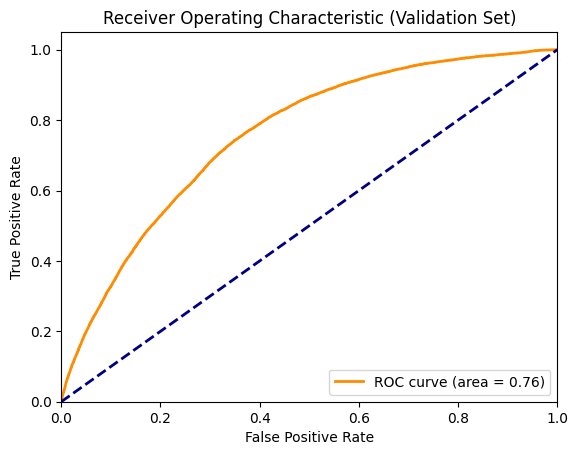

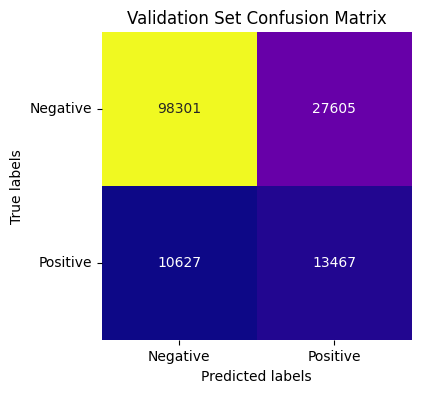

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84    126052
           1       0.32      0.56      0.41     23948

    accuracy                           0.74    150000
   macro avg       0.61      0.67      0.62    150000
weighted avg       0.81      0.74      0.77    150000

Test Set Accuracy: 0.7433533333333333
Test Set Precision: 0.32413026134468004
Test Set Recall: 0.5598379822949724
Test Set F1 Score: 0.4105587113962426
Test Set ROC AUC: 0.7533902066213752


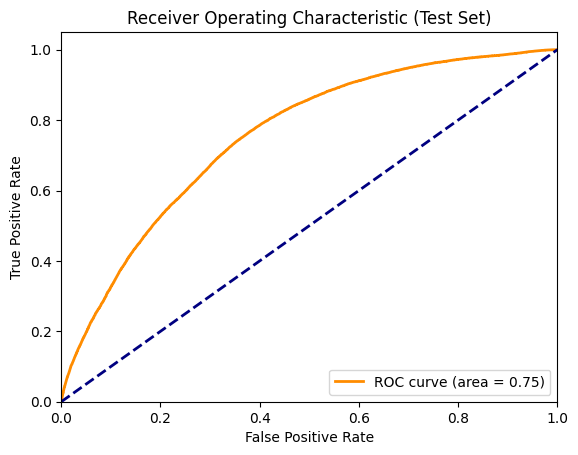

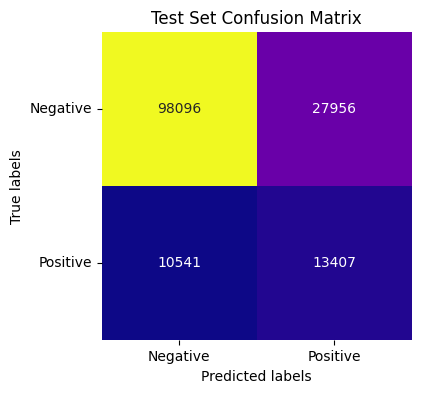

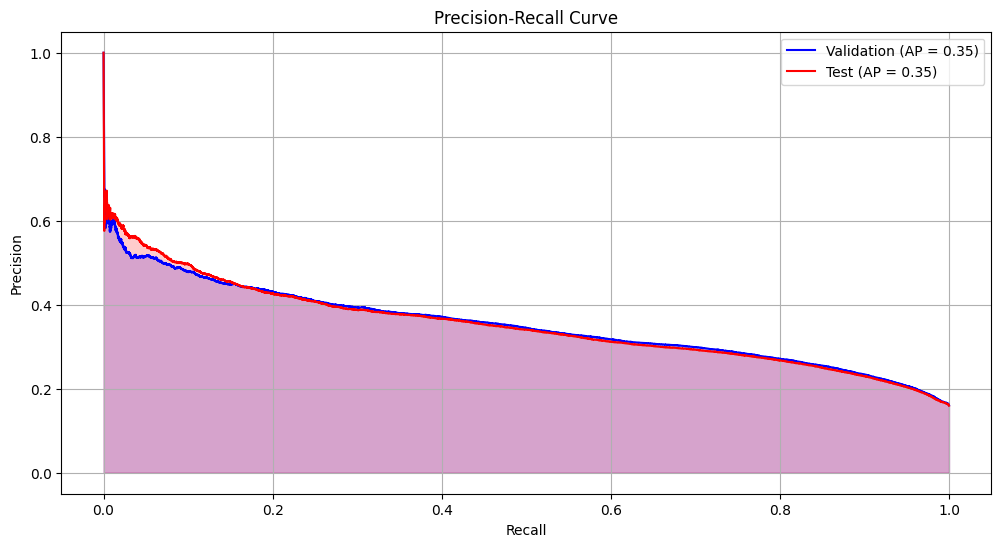

In [36]:
dense_numerical = list(X_train_oversampled.columns) # Creating a list of train data
dense_numerical_features = [DenseFeat(feat, 1) for feat in dense_numerical] 
linear_features = dense_numerical_features
DNN_features = dense_numerical_features
feature_names = [feat.name for feat in linear_features + DNN_features]
train_model_input = {name: X_train_oversampled[name] for name in feature_names}
val_model_input = {name: X_val_scaled[name] for name in feature_names}
test_model_input = {name: X_test_scaled[name] for name in feature_names}

# Creating a DEEPFM model
DNNmodel = DeepFM(linear_features, DNN_features, task='binary', dnn_dropout=0.2, dnn_hidden_units=(128, 64, 32))
optimizer = 'SGD'  # Using Stochasting Gradient Descent Optimizer
DNNmodel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

# Implementing learning rate scheduling
# Callback for reducing the learning rate on a plateau.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Stopping training if the loss doesn't improve for a specified number of epochs.
es_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = DNNmodel.fit(train_model_input, y_train_oversampled,
                       batch_size=256,
                       epochs=50,
                       verbose=1,
                       validation_data=(val_model_input, y_val),
                       callbacks=[reduce_lr, es_callback])

# Predicting probabilities on Validation Set.
y_val_DNNpred_probs = DNNmodel.predict(val_model_input, batch_size=256)

# If the predicted probability is greater than 0.5 classified as 1 or classified as 0.
y_val_DNNpreds = np.where(y_val_DNNpred_probs > 0.5, 1, 0)

# Evaluating models performance on Validation set
evaluate_model(y_val, y_val_DNNpreds, y_val_DNNpred_probs, dataset_name="Validation")

# Doing the same for the testing data
y_test_DNNpred_probs = DNNmodel.predict(test_model_input, batch_size=256)

test_preds = np.where(y_test_DNNpred_probs > 0.5, 1, 0)

accuracies.append(accuracy_score(y_test, test_preds))
precisions.append(precision_score(y_test, test_preds))
recalls.append(recall_score(y_test, test_preds))
f1_scores.append(f1_score(y_test, test_preds))
roc_aucs.append(roc_auc_score(y_test, y_test_DNNpred_probs))

evaluate_model(y_test, test_preds, y_test_DNNpred_probs, dataset_name="Test")

# Calculating precision and recall values for the validation set
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_DNNpred_probs[:, 0])

# Average precision (AP) score for the validation set
average_precision_val = average_precision_score(y_val, y_val_DNNpred_probs[:, 0])

# Doing the same for test set
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_DNNpred_probs[:, 0])

average_precision_test = average_precision_score(y_test, y_test_DNNpred_probs[:, 0])

plt.figure(figsize=(12, 6))
plt.plot(recall_val, precision_val, color='blue', label=f'Validation (AP = {average_precision_val:.2f})')
plt.plot(recall_test, precision_test, color='red', label=f'Test (AP = {average_precision_test:.2f})')
plt.fill_between(recall_val, precision_val, color='blue', alpha=0.2)
plt.fill_between(recall_test, precision_test, color='red', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss for Deep Learning Model

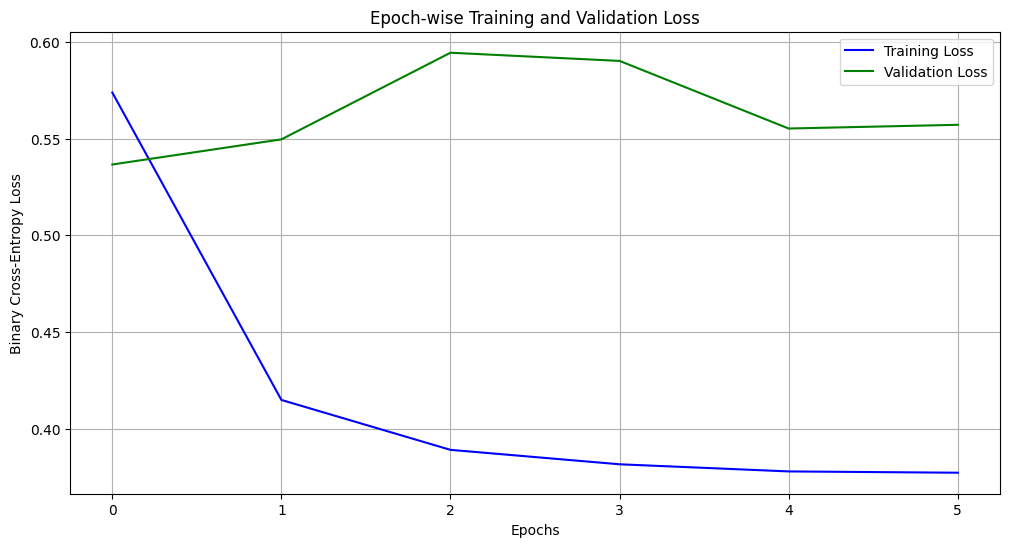

In [37]:
# Extract training loss from the history object
training_losses_DL = history.history['loss']

# Extract validation loss from the history object
validation_losses_DL = history.history['val_loss']

# Plotting the losses
plt.figure(figsize=(12, 6))
plt.plot(training_losses_DL, label='Training Loss', color='blue')
plt.plot(validation_losses_DL, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Epoch-wise Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

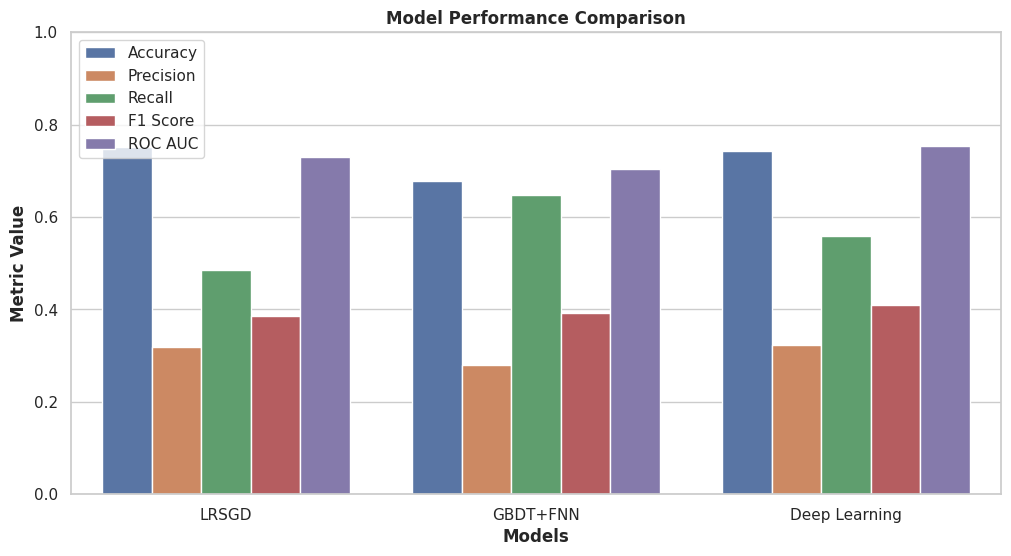

In [38]:
models = ['LRSGD', 'GBDT+FNN', 'Deep Learning']
data = {'Models': models, 'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1_scores, 'ROC AUC': roc_aucs}
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="Models", y="value", hue="variable", data=pd.melt(df, ['Models']))
plt.xlabel('Models', fontweight='bold')
plt.title('Model Performance Comparison', fontweight='bold')
plt.ylabel('Metric Value', fontweight='bold')
plt.ylim(0, 1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='', loc='upper left')
plt.show()